In [1]:
import torch
import numpy as np
from torch import Tensor
import pandas as pd
import omegaconf

from matplotlib import rc_file
rc_file("../../matplotlibrc")

import sys
import os
__file__ = os.path.abspath('')
sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

from labproject.metrics.MMD import *

In [2]:
ws_hat = [.6,.4]
sds_hat = [1,2]
us_hat = [4,-6]

p1 = torch.distributions.Normal(us_hat[0], sds_hat[0]).sample((5000,))

u_hat = 0
sd_hat = np.sqrt(ws_hat[0]*sds_hat[0]**2 + ws_hat[1]*sds_hat[1]**2 +ws_hat[0]*us_hat[0]**2+ws_hat[1]*us_hat[1]**2-(ws_hat[0]*us_hat[0]+ws_hat[1]*us_hat[1])**2)

sd_1=sd_hat
u1 = 0

# Define the number of Gaussian components in the mixture
N = len(ws_hat)

# Define Bernoulli distributions for choosing between components
bernoulli_dists = [torch.distributions.Bernoulli(torch.tensor(weight)) for weight in ws_hat]

# Initialize an empty list to store samples from each component
gaussian_samples = []

# Sample a total of 1000 samples from the Gaussian mixture model
total_samples = 5000
samples_count = 0

while samples_count < total_samples:
    # Sample from each Bernoulli distribution to decide which component to sample from
    bernoulli_samples = [bernoulli_dist.sample() for bernoulli_dist in bernoulli_dists]

    # Sample from each Gaussian component based on the outcomes of the Bernoulli samples
    for i in range(N):
        if samples_count < total_samples:
            if bernoulli_samples[i].item() == 0:  # Sample from the ith Gaussian component
                gaussian_sample = torch.distributions.Normal(us_hat[i], sds_hat[i]).sample()
                gaussian_samples.append(gaussian_sample)
                samples_count += 1

# Convert the list of samples to a PyTorch tensor
gaussian_samples_tensor = torch.stack(gaussian_samples)

In [3]:
class Metric:
    def __init__(self, name: str, func: callable, **kwargs):
        self.name = name
        self.func = func
        self.kwargs = kwargs

    def __call__(self, x: Tensor, y: Tensor) -> Tensor:
        return self.func(x, y, **self.kwargs)

class DistComp:
    def __init__(self, dataset1: Tensor, dataset2: Tensor, metric: Metric, 
                 n_perms: int = 1, perm_size=5000, descr=""):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.metric = metric
        self.n_perms = n_perms
        self.perm_size = perm_size
        self.descr = descr

        columns = [metric.name]
        self.results_df = pd.DataFrame(np.nan, index=range(self.n_perms), columns=columns)

    def run_experiment(self):
        for i in range(self.n_perms):
            dataset2_perm = self.dataset2[torch.randperm(len(self.dataset2))[:self.perm_size]]
            dataset1_perm = self.dataset1[torch.randperm(len(self.dataset1))[:self.perm_size]]
            self.results_df.loc[i, self.metric.name] = self.metric(dataset1_perm, dataset2_perm).item()
    
    def reformat_df(self, data):
        """
        reformat the results_df to work with seaborn plot expectations.
        """
        metric = [column_name for _, row in data.iterrows() for column_name, _ in row.items()]
        split_ind = [i for i, _ in data.iterrows() for _ in range(len(data.columns))]
        distance = [value for _, row in data.iterrows() for _, value in row.items()]

        return pd.DataFrame({"metric": metric, "distance": distance, "split_ind": split_ind})
        

In [4]:
metrics = []
gammas = np.linspace(0.5, 10, 11)
for gamma in gammas:
    metrics.append(Metric(f'{gamma}', mmd_rbf, gamma=gamma))

datasets = [
    (gaussian_samples_tensor, gaussian_samples_tensor ),
    (gaussian_samples_tensor, p1),
]

descr_list = [r'$p_{true} - p_{true}$', r'$p_{true} - p_{1}$']

experiments = []

for metric in metrics:
    for dataset, descr in zip(datasets, descr_list):
        experiments.append(
            DistComp(dataset[0].unsqueeze(1), dataset[1].unsqueeze(1), metric, n_perms=1, perm_size=1000, descr=descr)
        )


for experiment in experiments:
    experiment.run_experiment()


/var/folders/sk/zqh6htjn4310mvxm1plmzny00000gn/T/ipykernel_91607/2739459404.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{tick:.2f}' for tick in gammas])
/var/folders/sk/zqh6htjn4310mvxm1plmzny00000gn/T/ipykernel_91607/2739459404.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.5f}' for tick in ax.get_yticks()])


-1.3471e-05

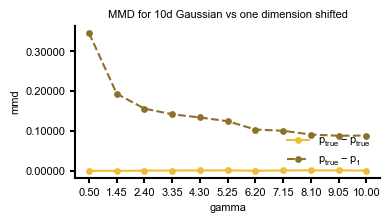

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def cm2inch(cm, INCH=2.54):
    if isinstance(cm, tuple):
        return tuple(i / INCH for i in cm)
    else:
        return cm / INCH

# Combine data from all experiments into a single dataframe
all_data = pd.concat([experiment.reformat_df(experiment.results_df).assign(experiment=experiment.descr) for experiment in experiments])

fig, ax = plt.subplots(figsize=cm2inch((10, 5)))

def generate_palette(hex_color, n_colors=5, saturation="light"):
    if saturation == "light":
        palette = sns.light_palette(hex_color, n_colors=n_colors, as_cmap=False)
    elif saturation == "dark":
        palette = sns.dark_palette(hex_color, n_colors=n_colors, as_cmap=False)
    return palette

col_dark = generate_palette("#eebd35", saturation='dark')[2]
col_light = generate_palette("#eebd35", saturation='light')[-1]

colors = [col_light, col_dark]

# Assign linestyles based on the experiment
linestyles = ['-', '--']  # solid line, dashed line

sns.pointplot(data=all_data, x="metric", y="distance", hue="experiment", ax=ax, palette=colors, linestyles=linestyles, linewidth=1.5)

# Format x-tick labels to show only the first two digits after the decimal point
ax.set_xticklabels([f'{tick:.2f}' for tick in gammas])
#do the same for the y axis
ax.set_yticklabels([f'{tick:.5f}' for tick in ax.get_yticks()])
ax.legend(loc='lower right')
ax.title.set_text('MMD for 10d Gaussian vs one dimension shifted')
ax.set_ylabel('mmd')
ax.set_xlabel('gamma')  
#plt.savefig("gamma.pdf",bbox_inches='tight',transparent=True)
-1.3471e-05

In [27]:
from functools import wraps
_name_map = {"X": 0, "Y": 1, "Z": 2}

class Matrix:
    def __init__(self, M, const_diagonal=False):
        self.mat = M = torch.as_tensor(M)
        self.m, self.n = self.shape = M.shape
        self._cache = {}

    @_cache
    def row_sums(self):
        return self.mat.sum(0)

    @_cache
    def col_sums(self):
        return self.mat.sum(1)

    @_cache
    def row_sums_sq_sum(self):
        sums = self.row_sums()
        return sums @ sums

    @_cache
    def col_sums_sq_sum(self):
        sums = self.col_sums()
        return sums @ sums

    @_cache
    def sum(self):
        if "row_sums" in self._cache:
            return self.row_sums().sum()
        elif "col_sums" in self._cache:
            return self.col_sums().sum()
        else:
            return self.mat.sum()

    def mean(self):
        return self.sum() / (self.m * self.n)

    @_cache
    def sq_sum(self):
        flat = self.mat.view(-1)
        return flat @ flat

    def __repr__(self):
        return f"<{type(self).__name__}, {self.m} by {self.n}>"


class SquareMatrix(Matrix):
    def __init__(self, M):
        super().__init__(M)
        assert self.m == self.n

    @_cache
    def diagonal(self):
        return self.mat.diagonal()

    @_cache
    def trace(self):
        return self.mat.trace()

    @_cache
    def sq_trace(self):
        diag = self.diagonal()
        return diag @ diag

    @_cache
    def offdiag_row_sums(self):
        return self.row_sums() - self.diagonal()

    @_cache
    def offdiag_col_sums(self):
        return self.col_sums() - self.diagonal()

    @_cache
    def offdiag_row_sums_sq_sum(self):
        sums = self.offdiag_row_sums()
        return sums @ sums

    @_cache
    def offdiag_col_sums_sq_sum(self):
        sums = self.offdiag_col_sums()
        return sums @ sums

    @_cache
    def offdiag_sum(self):
        return self.offdiag_row_sums().sum()

    def offdiag_mean(self):
        return self.offdiag_sum() / (self.n * (self.n - 1))

    @_cache
    def offdiag_sq_sum(self):
        return self.sq_sum() - self.sq_trace()


class SymmetricMatrix(SquareMatrix):
    def col_sums(self):
        return self.row_sums()

    def sums(self):
        return self.row_sums()

    def offdiag_col_sums(self):
        return self.offdiag_row_sums()

    def offdiag_sums(self):
        return self.offdiag_row_sums()

    def col_sums_sq_sum(self):
        return self.row_sums_sq_sum()

    def sums_sq_sum(self):
        return self.row_sums_sq_sum()

    def offdiag_col_sums_sq_sum(self):
        return self.offdiag_row_sums_sq_sum()

    def offdiag_sums_sq_sum(self):
        return self.offdiag_row_sums_sq_sum()


class ConstDiagMatrix(SquareMatrix):
    def __init__(self, M, diag_value):
        super().__init__(M)
        self.diag_value = diag_value

    @_cache
    def diagonal(self):
        return self.mat.new_full((1,), self.diag_value)

    def trace(self):
        return self.n * self.diag_value

    def sq_trace(self):
        return self.n * (self.diag_value ** 2)
class SymmetricConstDiagMatrix(ConstDiagMatrix, SymmetricMatrix):
    pass


def as_matrix(M, const_diagonal=False, symmetric=False):
    if symmetric:
        if const_diagonal is not False:
            return SymmetricConstDiagMatrix(M, diag_value=const_diagonal)
        else:
            return SymmetricMatrix(M)
    elif const_diagonal is not False:
        return ConstDiagMatrix(M, diag_value=const_diagonal)
    elif M.shape[0] == M.shape[1]:
        return SquareMatrix(M)
    else:
        return Matrix(M)

def as_tensors(X, *rest):
    "Calls as_tensor on a bunch of args, all of the first's device and dtype."
    X = torch.as_tensor(X)
    return [X] + [
        None if r is None else torch.as_tensor(r, device=X.device, dtype=X.dtype)
        for r in rest
    ]

class MMDStatistic:
    r"""The *unbiased* MMD test of :cite:`gretton2012kernel`.
    The kernel used is equal to:
    .. math ::
        k(x, x') = \sum_{j=1}^k e^{-\alpha_j\|x - x'\|^2},
    for the :math:`\alpha_j` proved in :py:meth:`~.MMDStatistic.__call__`.
    Arguments
    ---------
    n_1: int
        The number of points in the first sample.
    n_2: int
        The number of points in the second sample."""

    def __init__(self, n_1, n_2):
        self.n_1 = n_1
        self.n_2 = n_2

        # The three constants used in the test.
        self.a00 = 1.0 / (n_1 * (n_1 - 1))
        self.a11 = 1.0 / (n_2 * (n_2 - 1))
        self.a01 = -1.0 / (n_1 * n_2)

    def __call__(self, sample_1, sample_2, alphas, ret_matrix=False):
        r"""Evaluate the statistic.
        The kernel used is
        .. math::
            k(x, x') = \sum_{j=1}^k e^{-\alpha_j \|x - x'\|^2},
        for the provided ``alphas``.
        Arguments
        ---------
        sample_1: :class:`torch:torch.autograd.Variable`
            The first sample, of size ``(n_1, d)``.
        sample_2: variable of shape (n_2, d)
            The second sample, of size ``(n_2, d)``.
        alphas : list of :class:`float`
            The kernel parameters.
        ret_matrix: bool
            If set, the call with also return a second variable.
            This variable can be then used to compute a p-value using
            :py:meth:`~.MMDStatistic.pval`.
        Returns
        -------
        :class:`float`
            The test statistic.
        :class:`torch:torch.autograd.Variable`
            Returned only if ``ret_matrix`` was set to true."""
        sample_12 = torch.cat((sample_1, sample_2), 0)
        distances = pdist(sample_12, sample_12, norm=2)

        kernels = None
        for alpha in alphas:
            kernels_a = torch.exp(-alpha * distances ** 2)
            if kernels is None:
                kernels = kernels_a
            else:
                kernels = kernels + kernels_a

        k_1 = kernels[: self.n_1, : self.n_1]
        k_2 = kernels[self.n_1 :, self.n_2 :]
        k_12 = kernels[: self.n_1, self.n_2 :]

        mmd = (
            2 * self.a01 * k_12.sum()
            + self.a00 * (k_1.sum() - torch.trace(k_1))
            + self.a11 * (k_2.sum() - torch.trace(k_2))
        )

        if ret_matrix:
            return mmd, kernels
        else:
            return mmd

def mmd2_unbiased(K):
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.mean()

class LazyKernel(torch.nn.Module):
    """
    Base class that allows computing kernel matrices among a bunch of datasets,
    only computing the matrices when we use them.

    Constructor arguments:
        - A bunch of matrices we'll compute the kernel among.
          2d tensors, with second dimension agreeing, or None;
          None is a special value meaning to use the first entry X.
          (This is more efficient than passing the same tensor again.)

    Access the results with:
      - K[0, 1] to get the Tensor between parts 0 and 1.
      - K.XX, K.XY, K.ZY, etc: shortcuts, with X=0, Y=1, Z=2.
      - K.matrix(0, 1) or K.XY_m: returns a Matrix subclass (see below).
    """

    def __init__(self, X, *rest):
        super().__init__()
        self._cache = {}
        if not hasattr(self, "const_diagonal"):
            self.const_diagonal = False

        # want to use pytorch buffer for parts
        # but can't assign a list to those, so munge some names
        X, *rest = as_tensors(X, *rest)
        if len(X.shape) < 2:
            raise ValueError(
                "LazyKernel expects parameters to be at least 2d. "
                "If your data is 1d, make it [n, 1] with X[:, np.newaxis]."
            )

        self.register_buffer("_part_0", X)
        self.n_parts = 1
        for p in rest:
            self.append_part(p)

    @property
    def X(self):
        return self._part_0

    def _part(self, i):
        return self._buffers[f"_part_{i}"]

    def part(self, i):
        p = self._part(i)
        return self.X if p is None else p

    def n(self, i):
        return self.part(i).shape[0]

    @property
    def ns(self):
        return [self.n(i) for i in range(self.n_parts)]

    @property
    def parts(self):
        return [self.part(i) for i in range(self.n_parts)]

    @property
    def dtype(self):
        return self.X.dtype

    @property
    def device(self):
        return self.X.device

    def __repr__(self):
        return f"<{type(self).__name__}({', '.join(str(n) for n in self.ns)})>"

    def _compute(self, A, B):
        """
        Compute the kernel matrix between A and B.

        Might get called with A = X, B = X, or A = X, B = Y, etc.

        Should return a tensor of shape [A.shape[0], B.shape[0]].

        This default, slow, version calls self._compute_one(a, b) in a loop.
        If you override this, you don't need to implement _compute_one at all.

        If you implement _precompute, this gets added to the signature here:
            self._compute(A, *self._precompute(A), B, *self._precompute(B)).
        The default _precompute returns an empty tuple, so it's _compute(A, B),
        but if you make a _precompute that returns [A_squared, A_cubed] then it's
            self._compute(A, A_squared, A_cubed, B, B_squared, B_cubed).
        """
        return torch.stack(
            [
                torch.stack([torch.as_tensor(self._compute_one(a, b)) for b in B])
                for a in A
            ]
        )

    def _compute_one(self, a, b):
        raise NotImplementedError(
            f"{type(self).__name__}: need to implement _compute or _compute_one"
        )

    def _precompute(self, A):
        """
        Compute something extra for each part A.

        Can be used to share computation between kernel(X, X) and kernel(X, Y).

        We end up calling basically (but with caching)
            self._compute(A, *self._precompute(A), B, *self._precompute(B))
        This default _precompute returns an empty tuple, so it's
            self._compute(A, B)
        But if you return [A_squared], it'd be
            self._compute(A, A_squared, B, B_squared)
        and so on.
        """
        return ()

    @_cache
    def _precompute_i(self, i):
        p = self._part(i)
        if p is None:
            return self._precompute_i(0)
        return self._precompute(p)

    @_cache
    def __getitem__(self, k):
        try:
            i, j = k
        except ValueError:
            raise KeyError("You should index kernels with pairs")

        A = self._part(i)
        if A is None:
            return self[0, j]

        B = self._part(j)
        if B is None:
            return self[i, 0]

        if i > j:
            return self[j, i].t()

        A_info = self._precompute_i(i)
        B_info = self._precompute_i(j)
        return self._compute(A, *A_info, B, *B_info)

    @_cache
    def matrix(self, i, j):
        if self._part(i) is None:
            return self.matrix(0, j)

        if self._part(j) is None:
            return self.matrix(i, 0)

        k = self[i, j]
        if i == j:
            return as_matrix(k, const_diagonal=self.const_diagonal, symmetric=True)
        else:
            return as_matrix(k)

    @_cache
    def joint(self, *inds):
        if not inds:
            return self.joint(*range(self.n_parts))
        return torch.cat([torch.cat([self[i, j] for j in inds], 1) for i in inds], 0)

    @_cache
    def joint_m(self, *inds):
        if not inds:
            return self.joint_m(*range(self.n_parts))
        return as_matrix(
            self.joint(*inds), const_diagonal=self.const_diagonal, symmetric=True
        )

    def __getattr__(self, name):
        # self.X, self.Y, self.Z
        if name in _name_map:
            i = _name_map[name]
            if i < self.n_parts:
                return self.part(i)
            else:
                raise AttributeError(f"have {self.n_parts} parts, asked for {i}")

        # self.XX, self.XY, self.YZ, etc; also self.XX_m
        ret_matrix = False
        if len(name) == 4 and name.endswith("_m"):
            ret_matrix = True
            name = name[:2]

        if len(name) == 2:
            i = _name_map.get(name[0], np.inf)
            j = _name_map.get(name[1], np.inf)
            if i < self.n_parts and j < self.n_parts:
                return self.matrix(i, j) if ret_matrix else self[i, j]
            else:
                raise AttributeError(f"have {self.n_parts} parts, asked for {i}, {j}")

        return super().__getattr__(name)

    def _invalidate_cache(self, i):
        for k in list(self._cache.keys()):
            if (
                i in k[1:]
                or any(isinstance(arg, tuple) and i in arg for arg in k[1:])
                or k in [("joint",), ("joint_m",)]
            ):
                del self._cache[k]

    def drop_last_part(self):
        assert self.n_parts >= 2
        i = self.n_parts - 1
        self._invalidate_cache(i)
        del self._buffers[f"_part_{i}"]
        self.n_parts -= 1

    def change_part(self, i, new):
        assert i < self.n_parts
        if new is not None and new.shape[1:] != self.X.shape[1:]:
            raise ValueError(f"X has shape {self.X.shape}, new entry has {new.shape}")
        self._invalidate_cache(i)
        self._buffers[f"_part_{i}"] = new

    def append_part(self, new):
        if new is not None and new.shape[1:] != self.X.shape[1:]:
            raise ValueError(f"X has shape {self.X.shape}, new entry has {new.shape}")
        self._buffers[f"_part_{self.n_parts}"] = new
        self.n_parts += 1

    def __copy__(self):
        """
        Doesn't deep-copy the data tensors, but copies dictionaries so that
        change_part/etc don't affect the original.
        """
        cls = self.__class__
        result = cls.__new__(cls)
        to_copy = {"_cache", "_buffers", "_parameters", "_modules"}
        result.__dict__.update(
            {k: v.copy() if k in to_copy else v for k, v in self.__dict__.items()}
        )
        return result

    def _apply(self, fn):  # used in to(), cuda(), etc
        super()._apply(fn)
        for key, val in self._cache.items():
            if val is not None:
                self._cache[key] = fn(val)
        return self

    def as_tensors(self, *args, **kwargs):
        "Helper that makes everything a tensor with self.X's type."
        kwargs.setdefault("device", self.X.device)
        kwargs.setdefault("dtype", self.X.dtype)
        return tuple(None if r is None else torch.as_tensor(r, **kwargs) for r in args)


################################################################################
# Matrix wrappers that cache sums / etc. Including various subclasses; see
# as_matrix() to pick between them appropriately.

# TODO: could support a matrix transpose that shares the cache appropriately


class ExpQuadKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
        self.const_diagonal = 1  # Says that k(x, x) = 1 for any x.
        # Just a slight optimization; not really necessary.

    # TODO: implement _compute (maybe with _precompute) or _compute_one
    def _precompute(self, A):
        # Squared norms of each data point
        return [torch.einsum("ij,ij->i", A, A)]

    def _compute(self, A, A_sqnorms, B, B_sqnorms):
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())
        return torch.exp(D2 / (-2 * self.sigma ** 2))

def get_default_device() -> torch.device:
    device = torch.ones((1,)).device
    return device

In [28]:
import itertools
import logging
import time

import numpy as np
import torch

log = logging.getLogger(__name__)

def mmd(
    X: torch.Tensor,
    Y: torch.Tensor,
    implementation: str = "tp_sutherland",
    z_score: bool = False,
    bandwidth: str = "X",
) -> torch.Tensor:
    """Estimate MMD^2 statistic with Gaussian kernel

    Currently different implementations are available, in order to validate accuracy and compare speeds. The widely used median heuristic for bandwidth-selection of the Gaussian kernel is used.
    """
    if torch.isnan(X).any() or torch.isnan(Y).any():
        return torch.tensor(float("nan"))

    tic = time.time()  # noqa

    if z_score:
        X_mean = torch.mean(X, axis=0)
        X_std = torch.std(X, axis=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    n_1 = X.shape[0]
    n_2 = Y.shape[0]

    # Bandwidth
    if bandwidth == "X":
        sigma_tensor = torch.median(torch.pdist(X))
    elif bandwidth == "XY":
        sigma_tensor = torch.median(torch.pdist(torch.cat([X, Y])))
    else:
        raise NotImplementedError

    # Compute MMD
    if implementation == "tp_sutherland":
        K = ExpQuadKernel(X, Y, sigma=sigma_tensor)
        statistic = mmd2_unbiased(K)

    elif implementation == "tp_djolonga":
        alpha = 1 / (2 * sigma_tensor ** 2)
        test = MMDStatistic(n_1, n_2)
        statistic = test(X, Y, [alpha])

    else:
        raise NotImplementedError

    toc = time.time()  # noqa
    # log.info(f"Took {toc-tic:.3f}sec")

    return statistic

In [39]:
datasets = [
    (gaussian_samples_tensor, gaussian_samples_tensor ),
    (gaussian_samples_tensor, p1),
]

experiments = []


for dataset in datasets:
    experiments.append(
        mmd(dataset[0].unsqueeze(1), dataset[1].unsqueeze(1))
    )


print('mmd but squared:', experiments)


mmd but squared: [tensor(-0.0002), tensor(0.5334)]


In [40]:
print('gamma: ', torch.median(torch.pdist(gaussian_samples_tensor.unsqueeze(1))).item())

gamma:  5.053723335266113
